In [ ]:
import pandas as pd
import sqlite3


def getSlotsFromDB(city: str, concern: str | None):

    conn = sqlite3.connect(f"db/{city}.db")

    sql = """
    SELECT 
        Availabilities.slot_id as s_id,
        Slots.office as office,
        Slots.city as city,
        Slots.timeslot as timeslot,
        Slots.concern as concern,
        Availabilities.id as a_id,
        Availabilities.available as available,
        Availabilities.taken as taken
    FROM Slots
    JOIN Availabilities ON Slots.id = Availabilities.slot_id;
    """

    df = pd.read_sql_query(sql, conn, parse_dates=["available", "taken", "timeslot"])

    conn.close()

    if concern:
        df = df[df["concern"] == concern]

    return df


df = getSlotsFromDB("duesseldorf", "Personalausweis - Antrag")

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35019 entries, 499 to 137973
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   s_id       35019 non-null  int64         
 1   office     35019 non-null  object        
 2   city       35019 non-null  object        
 3   timeslot   35019 non-null  datetime64[ns]
 4   concern    35019 non-null  object        
 5   a_id       35019 non-null  int64         
 6   available  35019 non-null  datetime64[ns]
 7   taken      34383 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(3)
memory usage: 2.4+ MB


In [105]:
# lose precision to only minutes
df["timeslot"] = df["timeslot"].dt.floor("min")
df["available"] = df["available"].dt.floor("min")
df["taken"] = df["taken"].dt.floor("min")

# timdelta between available and taken
df["delta"] = df["taken"] - df["available"]


# # convert to string
# open_slots_over_time["timeslot"] = open_slots_over_time["timeslot"].dt.strftime("%a %d.%m. %H:%M")
# open_slots_over_time["available"] = open_slots_over_time["available"].dt.strftime("%a %d.%m. %H:%M")
# open_slots_over_time["taken"] = open_slots_over_time["taken"].dt.strftime("%a %d.%m. %H:%M")

df

,s_id,office,city,timeslot,concern,a_id,available,taken,delta
499,500,Benrath,Duesseldorf,2024-10-28 12:40:00,Personalausweis - Antrag,500,2024-10-27 14:01:00,2024-10-27 14:09:00,0 days 00:08:00
500,501,Dienstleistungszentrum,Duesseldorf,2024-11-11 11:15:00,Personalausweis - Antrag,501,2024-10-27 14:01:00,2024-10-27 14:19:00,0 days 00:18:00
501,502,Dienstleistungszentrum,Duesseldorf,2024-11-11 11:20:00,Personalausweis - Antrag,502,2024-10-27 14:01:00,2024-10-27 14:19:00,0 days 00:18:00
502,503,Dienstleistungszentrum,Duesseldorf,2024-11-11 11:25:00,Personalausweis - Antrag,503,2024-10-27 14:01:00,2024-10-27 14:19:00,0 days 00:18:00
503,504,Dienstleistungszentrum,Duesseldorf,2024-11-11 11:30:00,Personalausweis - Antrag,504,2024-10-27 14:01:00,2024-10-27 14:19:00,0 days 00:18:00
...,...,...,...,...,...,...,...,...,...
137969,40642,Gerresheim,Duesseldorf,2024-11-04 14:05:00,Personalausweis - Antrag,137970,2024-11-04 11:58:00,NaT,NaT
137970,40643,Gerresheim,Duesseldorf,2024-11-04 14:10:00,Personalausweis - Antrag,137971,2024-11-04 11:58:00,NaT,NaT
137971,40644,Gerresheim,Duesseldorf,2024-11-04 14:15:00,Personalausweis - Antrag,137972,2024-11-04 11:58:00,NaT,NaT
137972,14469,Dienstleistungszentrum,Duesseldorf,2024-11-04 12:35:00,Personalausweis - Antrag,137973,2024-11-04 11:59:00,NaT,NaT


In [106]:
# get all unique timestamps from available and taken
timestamps = pd.concat([df["available"], df["taken"]]).sort_values().unique()
timestamps

<DatetimeArray>
['2024-10-27 14:01:00', '2024-10-27 14:03:00', '2024-10-27 14:08:00',
 '2024-10-27 14:09:00', '2024-10-27 14:19:00', '2024-10-27 14:21:00',
 '2024-10-27 14:23:00', '2024-10-27 14:27:00', '2024-10-27 14:28:00',
 '2024-10-27 14:31:00',
 ...
 '2024-11-04 11:47:00', '2024-11-04 11:50:00', '2024-11-04 11:51:00',
 '2024-11-04 11:52:00', '2024-11-04 11:54:00', '2024-11-04 11:55:00',
 '2024-11-04 11:57:00', '2024-11-04 11:58:00', '2024-11-04 11:59:00',
                 'NaT']
Length: 2446, dtype: datetime64[ns]

In [107]:
count = []
for timestamp in timestamps:
    
    # count slots for each timestamp
    count_per_timestamp = df[
        (df["available"] <= timestamp) & ((df["taken"] >= timestamp) | (df["taken"].isnull()))
    ].shape[0]

    count.append(count_per_timestamp)

count_df = pd.DataFrame({"timestamp": timestamps, "count": count})

count_df


,timestamp,count
0,2024-10-27 14:01:00,250
1,2024-10-27 14:03:00,250
2,2024-10-27 14:08:00,253
3,2024-10-27 14:09:00,253
4,2024-10-27 14:19:00,252
...,...,...
2441,2024-11-04 11:55:00,650
2442,2024-11-04 11:57:00,646
2443,2024-11-04 11:58:00,643
2444,2024-11-04 11:59:00,636


<Axes: xlabel='timestamp'>

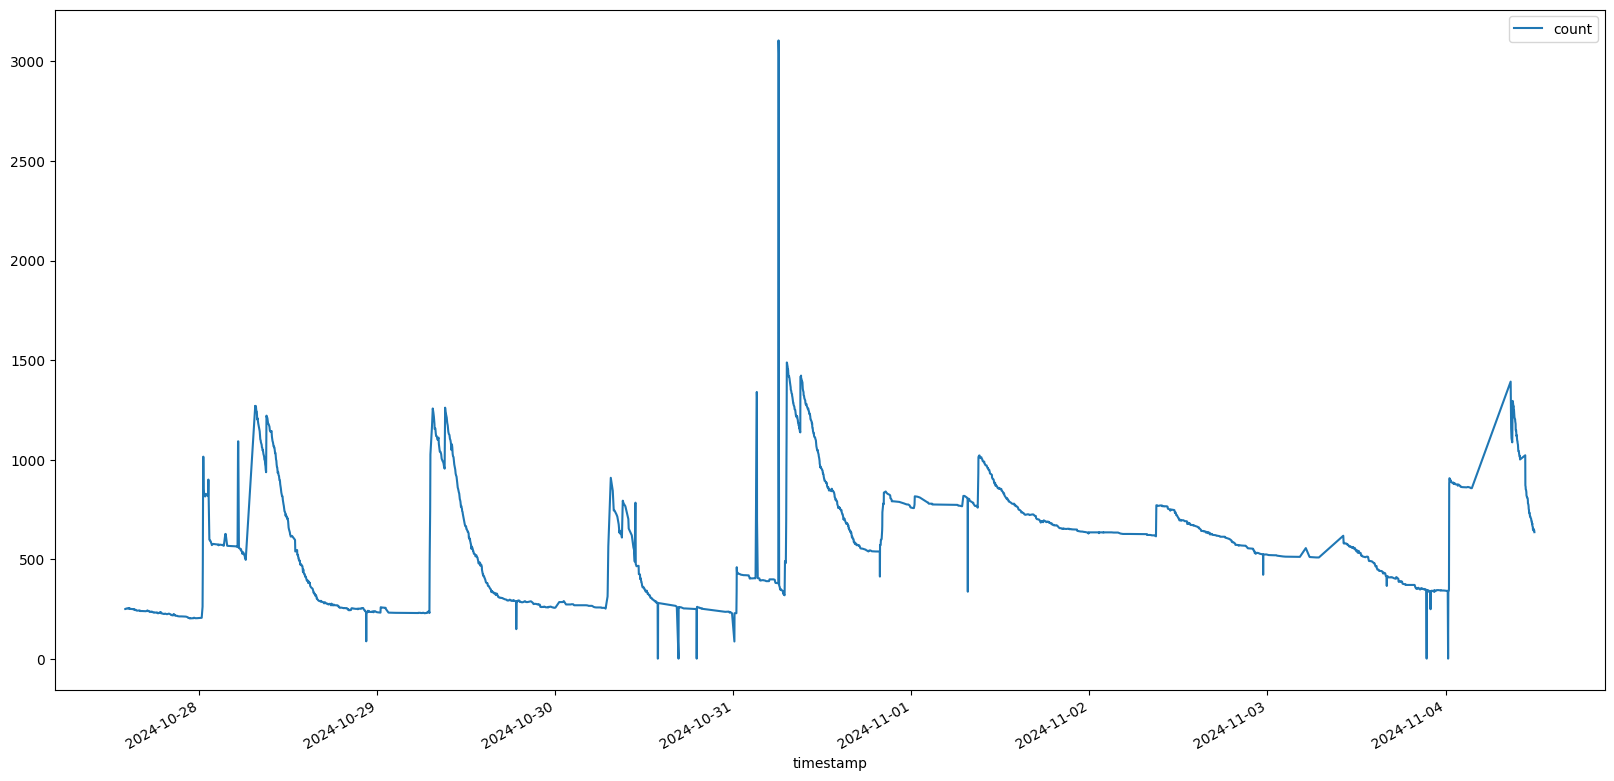

In [108]:
count_df.plot(x="timestamp", y="count", kind="line",figsize=(20,10))